# SAMap results
With leiden-based neighborhoods

In [1]:
from samap.mapping import SAMAP
from samap.analysis import (sankey_plot, get_mapping_scores)
from samalg import SAM
import pandas as pd
import numpy
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import scanpy as sc
import warnings
warnings.filterwarnings(action='ignore')
import pickle
import anndata as ad
import holoviews as hv

## Read and set parameters

Read parameters and SAMap object from preprocessing

In [2]:
with open('samap_parameters.csv') as f:
    config=[tuple(line) for line in csv.reader(f)]

config=dict(config)

for key,val in config.items():
    exec(key + '=val')

with open('sam_processed.pkl', 'rb') as inp:
    sm = pickle.load(inp)

Set new parameters

In [9]:
# optional cell assignment (one cell per line, output from
# R writeLines(seu_object$celltype,con = 'alt_celltypes.txt'))
alt_celltype_file_A=""
alt_celltype_file_B=""

# cell types to be shown extra
celltype_selection_A=['DorsalBlastoporeLip','AxialMesendoderm', 'PosteriorDorsalMesendoderm']
celltype_selection_B=['Blastopore Lip','Oral Ectoderm']

# show expression for markers (max 5, can get ugly if more)
markers_A=['Six3/6','Six4/5','Cerberus','Dmbx','Fz5/8']
markers_B=['Six3-6','Six4-5','GSC','FoxA','OtxC','OtxB']

Show all parameters

In [4]:
contrast=sp_stage_A+'_vs_'+sp_stage_B
print('contrast: '+contrast)
print('alt_celltype_file_A: '+alt_celltype_file_A)
print('alt_celltype_file_B: '+alt_celltype_file_B)
pd.DataFrame.from_dict(config,orient='index',dtype='str')

contrast: AmpG4_vs_NV24hr
alt_celltype_file_A: 
alt_celltype_file_B: 


,0
sp_stage_A,AmpG4
abbr_A,bf
h5ad_A,Amp_G4.h5ad
sp_stage_B,NV24hr
abbr_B,nv
h5ad_B,Gastrula24hrFINAL.h5ad
g_map_folder,./maps_prot/


## Add alternative annotation of celltypes

In [5]:
celltype_col_A='celltype_fine'
celltype_col_B='cell_type'
if ( alt_celltype_file_A != "" ):
    with open(alt_celltype_file_A) as f:
        alt_celltypes_A = f.read().splitlines()
    sm.sams[abbr_A].adata.obs['cell_type_alt']=alt_celltypes_A
    celltype_col_A='cell_type_alt'

if ( alt_celltype_file_B != "" ):
    with open(alt_celltype_file_B) as f:
        alt_celltypes_B = f.read().splitlines()
    sm.sams[abbr_B].adata.obs['cell_type_alt']=alt_celltypes_B
    celltype_col_B='cell_type_alt'

concat_ads=ad.concat({sp_stage_A:sm.sams[abbr_A].adata,
                     sp_stage_B:sm.sams[abbr_B].adata}, label="dataset")

## Visualizing the combined projection

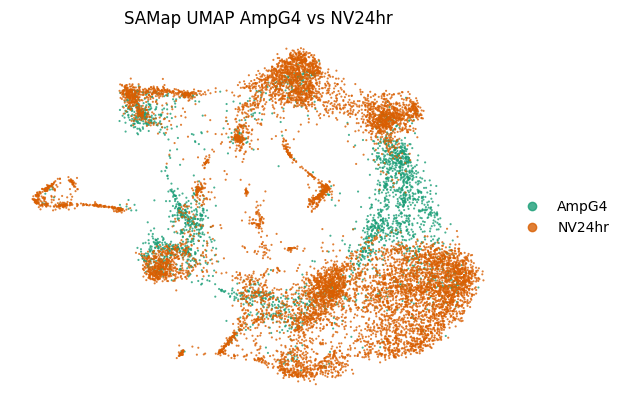

In [6]:
sc.pl.embedding(concat_ads,
                    basis='X_umap_samap',
                    color='dataset',
                frameon=False,
                title='SAMap UMAP '+sp_stage_A+' vs '+sp_stage_B,
                palette={sp_stage_A:('#1b9e77',0.8),sp_stage_B:('#d95f02',0.8)})

Visualise both objects with celltypes

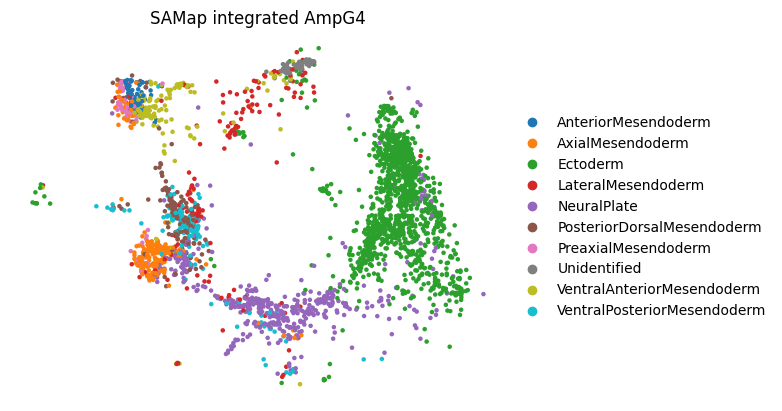

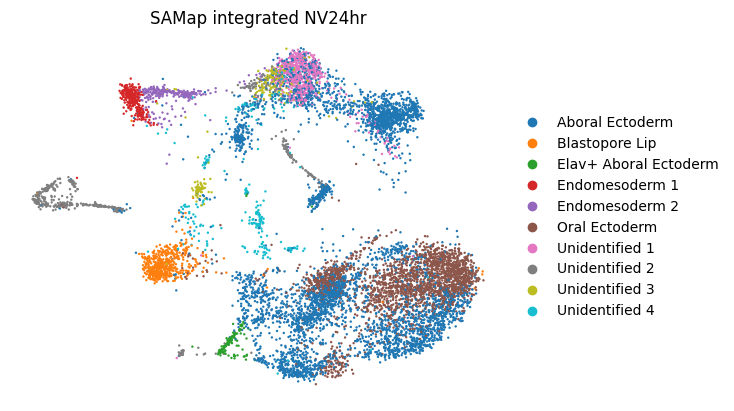

In [7]:
sc.pl.embedding(sm.sams[abbr_A].adata,
                    basis='X_umap_samap',
                    color=celltype_col_A,
                title=('SAMap integrated '+sp_stage_A),
                    frameon=False,save='_'+sp_stage_A+'_int_celltypes.pdf')
sc.pl.embedding(sm.sams[abbr_B].adata,
                    basis='X_umap_samap',
                title=('SAMap integrated '+sp_stage_B),
                    color=celltype_col_B,
                    frameon=False,save='_'+sp_stage_B+'_int_celltypes.pdf')

### Selected celltype visualisation

<Axes: title={'center': 'SAMap integrated NV24hr'}, xlabel='X_umap_samap1', ylabel='X_umap_samap2'>

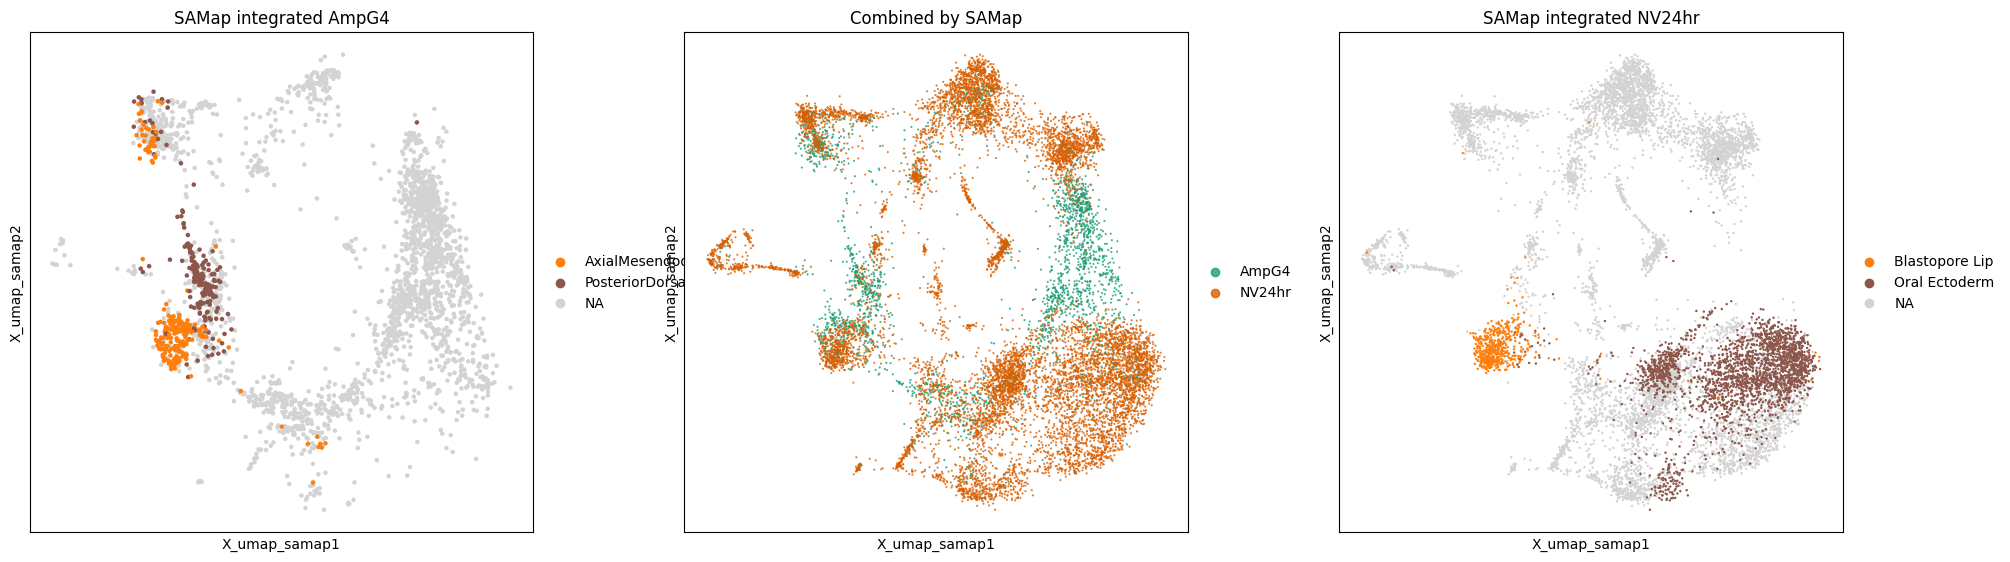

In [10]:
ncols = 3
nrows = 1
figsize =6.5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)

sc.pl.embedding(sm.sams[abbr_A].adata,
                    basis='X_umap_samap',
                    color=celltype_col_A,
                    groups=celltype_selection_A,
                    frameon=True,
                   title=('SAMap integrated '+sp_stage_A),ax=axs[0], show=False)

sc.pl.embedding(concat_ads,
                    basis='X_umap_samap',
                    color='dataset',
                frameon=True,
                title='Combined by SAMap',
                palette={sp_stage_A:('#1b9e77',0.8),sp_stage_B:('#d95f02',0.8)},ax=axs[1],show=False)

sc.pl.embedding(sm.sams[abbr_B].adata,
                    basis='X_umap_samap',
                    color=celltype_col_B,
                    groups=celltype_selection_B,
                    frameon=True,
                   title=('SAMap integrated '+sp_stage_B),ax=axs[2], show=False)

### Marker expression species A

AmpG4 markers


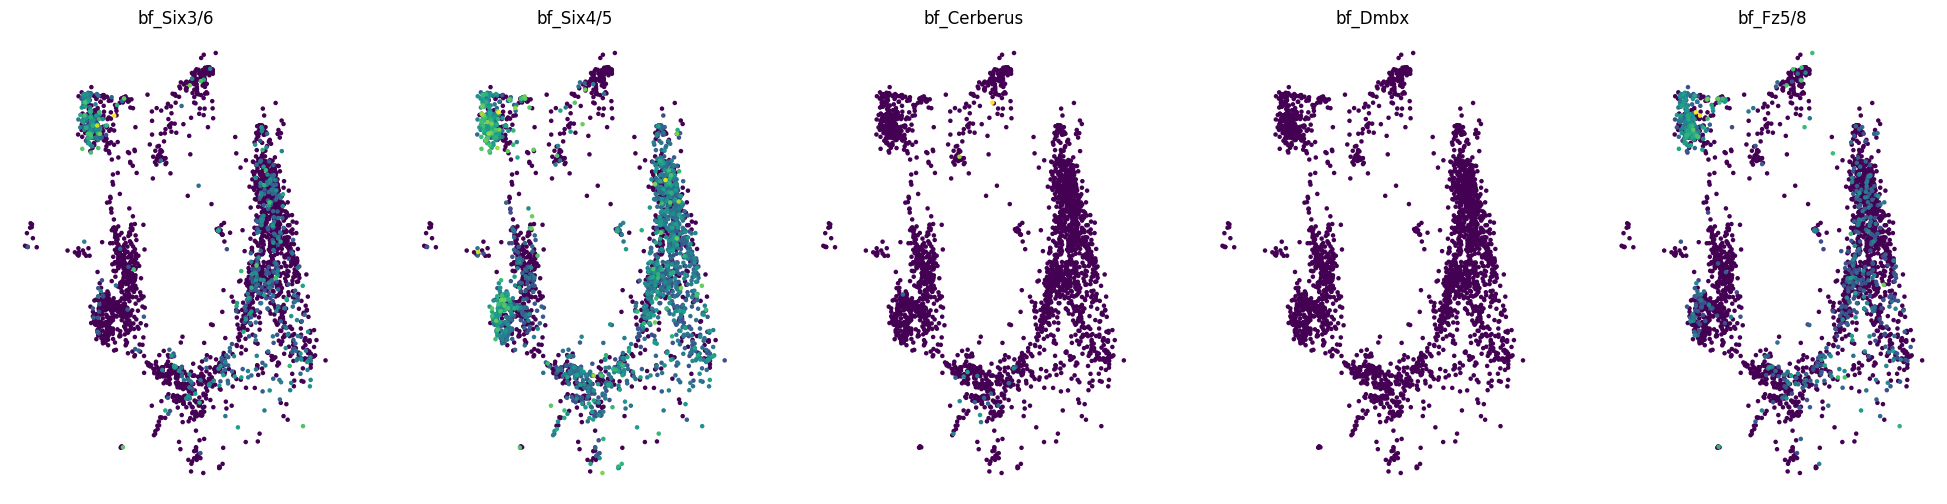

In [11]:
print(sp_stage_A+' markers')
with rc_context({"figure.figsize": (4, 6)}):
    sc.pl.embedding(sm.sams[abbr_A].adata,
                    basis='X_umap_samap',
                    color=[abbr_A+'_'+x for x in markers_A],
                    frameon=False,
                    colorbar_loc=None,
                    ncols=5)

### Marker expresison species B

NV24hr markers


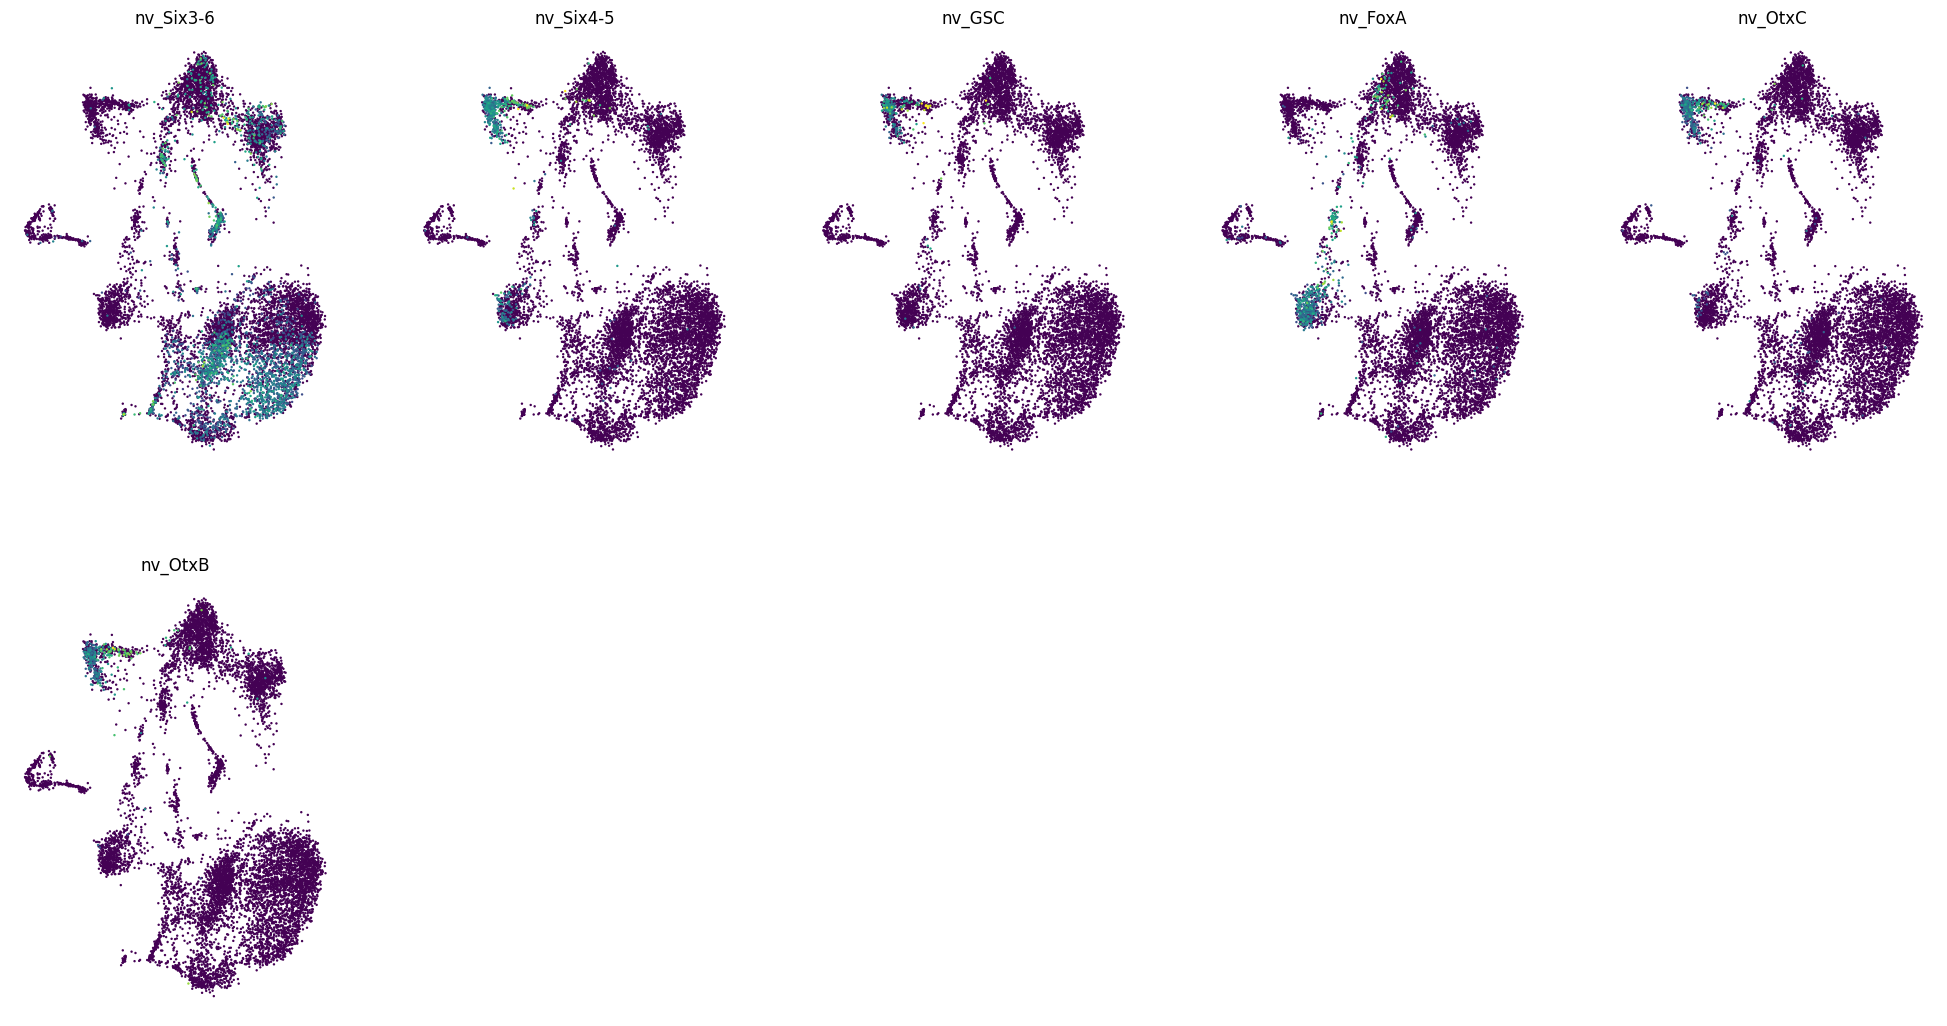

In [12]:
print(sp_stage_B+' markers')
with rc_context({"figure.figsize": (4, 6)}):
    sc.pl.embedding(sm.sams[abbr_B].adata,
                    basis='X_umap_samap',
                    color=[abbr_B+'_'+x for x in markers_B],
                    frameon=False,
                    colorbar_loc=None,
                    ncols=5)

### Markers side by side

<Axes: title={'center': 'nv_Six3-6'}, xlabel='X_umap_samap1', ylabel='X_umap_samap2'>

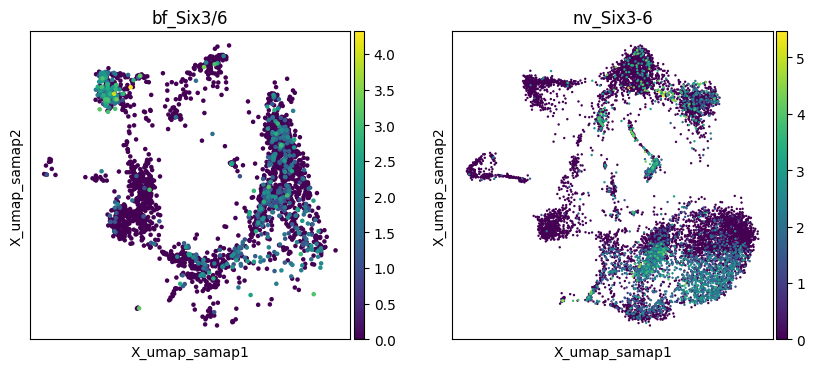

In [13]:
single_marker_A = "Six3/6"
single_marker_B = "Six3-6"

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10,4),
)

sc.pl.embedding(sm.sams[abbr_A].adata,
                basis='X_umap_samap',
                color=[abbr_A+'_'+single_marker_A],
                ax=axs[0],show=False)

sc.pl.embedding(sm.sams[abbr_B].adata,
                basis='X_umap_samap',
                color=[abbr_B+'_'+single_marker_B],
                ax=axs[1],show=False)


## Cell type mapping scores

In [14]:
D50_fine,MappingTable50_fine = get_mapping_scores(sm,{abbr_A : celltype_col_A, abbr_B : celltype_col_B},n_top = 50)
MappingTable50_fine.filter(like=abbr_A+"_").filter(axis='index',like=abbr_B+"_").to_csv('Mapping_table_top50_'+contrast+'.csv')

Heatmap of celltype homology

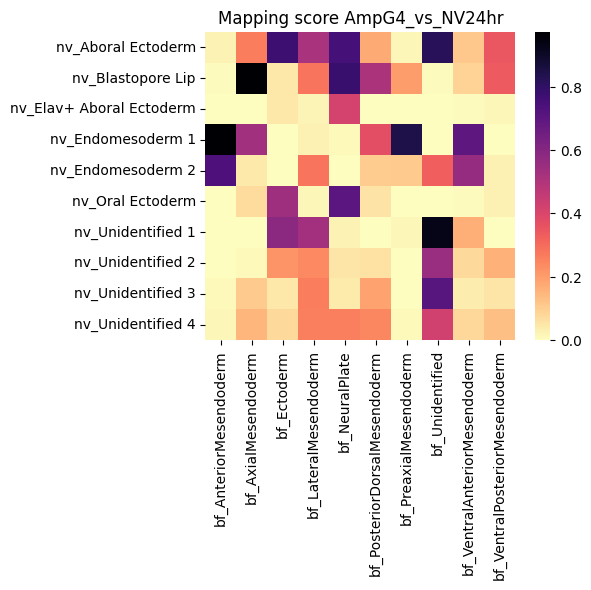

In [15]:
plt.gcf().set_size_inches(len(sm.sams[abbr_B].adata.obs[celltype_col_B].unique())/2,
                         (len(sm.sams[abbr_A].adata.obs[celltype_col_A].unique())/2)-1)
plt.title('Mapping score '+contrast)
sns.heatmap(MappingTable50_fine.filter(like=abbr_A+"_").filter(axis='index',like=abbr_B+"_"),cmap="magma_r",xticklabels=True,yticklabels=True)#,ax=ax)#[0])
plt.savefig('figures/hm_celltype_'+contrast+'.pdf',bbox_inches='tight')
plt.savefig('figures/hm_celltype_'+contrast+'.png',dpi=250,bbox_inches='tight')

Sankey plot

In [17]:
sankey_plot(MappingTable50_fine, align_thr=0.05, species_order = [abbr_A,abbr_B])

:Sankey   [source,target]   (Value)

## Others

### Export stacked plots

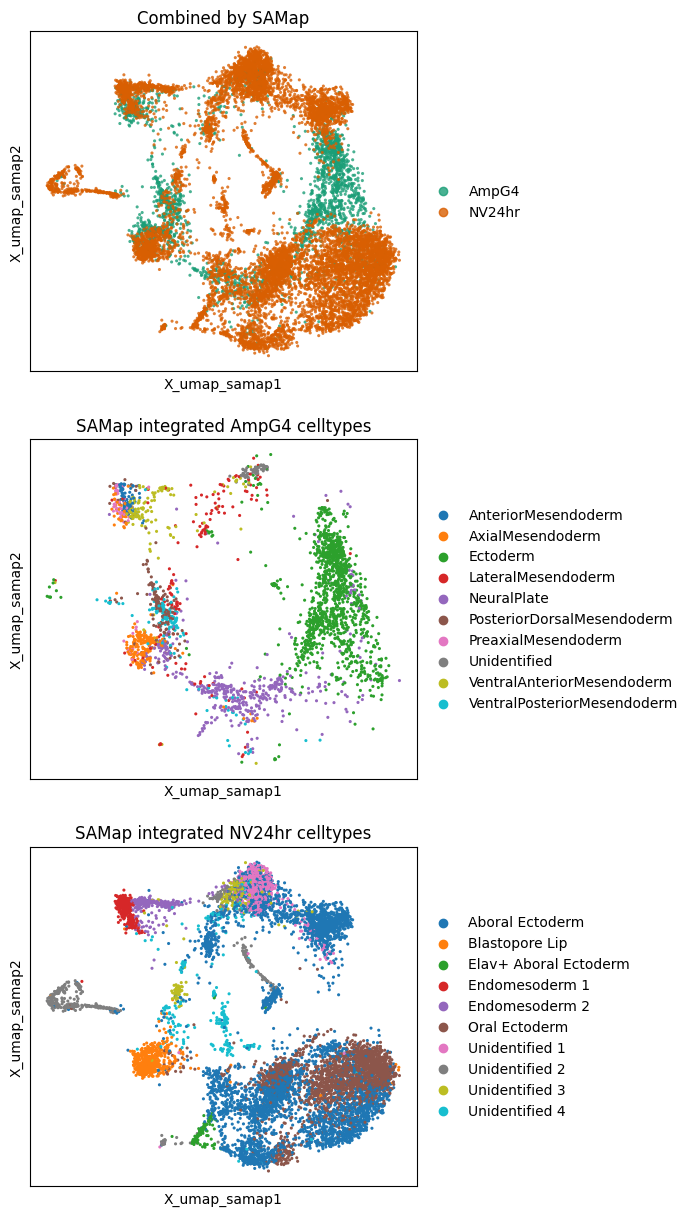

In [18]:
ncols = 1
nrows = 3
figsize = 5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)

sc.pl.embedding(concat_ads,
                    basis='X_umap_samap',
                    color='dataset',
                frameon=True,
                title='Combined by SAMap',
                size=20,
                ax=axs[0],
                palette={sp_stage_A:('#1b9e77',0.8),sp_stage_B:('#d95f02',0.8)},
               show=False)


sc.pl.embedding(sm.sams[abbr_A].adata,
                    basis='X_umap_samap',
                    color=celltype_col_A,
                    frameon=True,
                ax=axs[1],
                show=False,
                title=('SAMap integrated '+sp_stage_A+' celltypes'),
               size=20)

sc.pl.embedding(sm.sams[abbr_B].adata,
                    basis='X_umap_samap',
                    color=celltype_col_B,
                    frameon=True,
                ax=axs[2],
                show=False,
                title=('SAMap integrated '+sp_stage_B+' celltypes'),
               size=20)

fig.savefig('figures/comparison_'+contrast+'.pdf',bbox_inches='tight')
fig.savefig('figures/comparison_'+contrast+'.png',bbox_inches='tight',dpi=300)

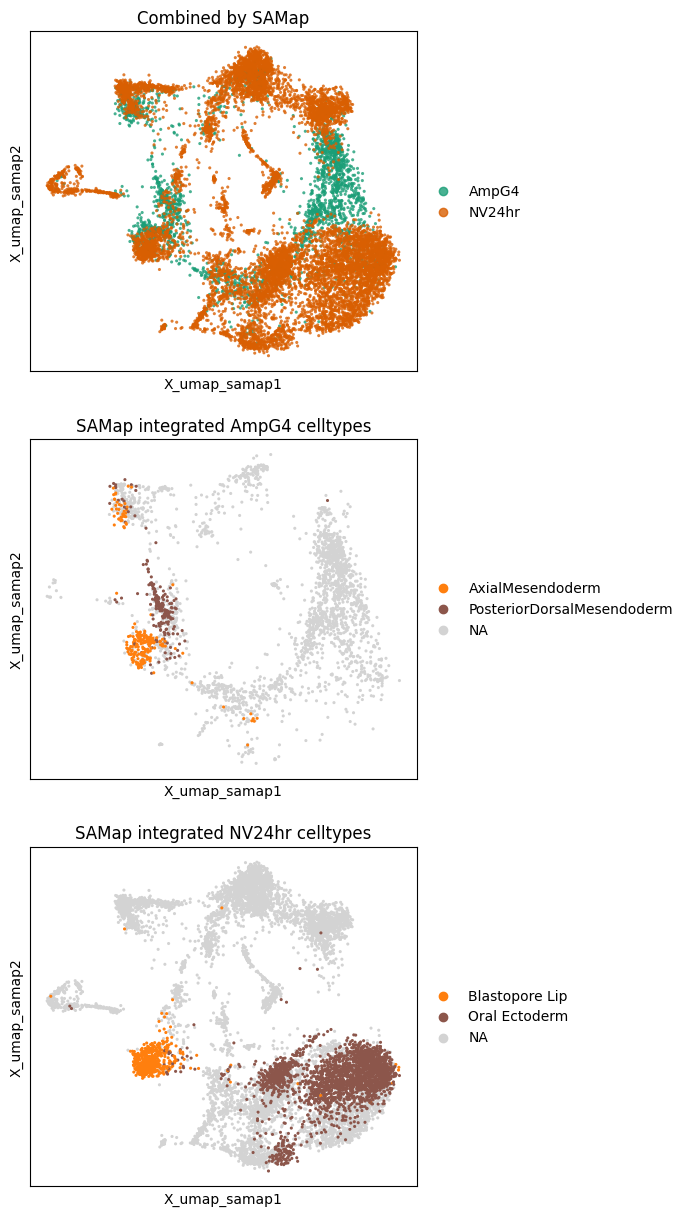

In [19]:
ncols = 1
nrows = 3
figsize = 5
wspace = 0.3
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)

plt.subplots_adjust(wspace=wspace)

sc.pl.embedding(sm.sams[abbr_A].adata,
                    basis='X_umap_samap',
                    color=celltype_col_A,
                    groups=celltype_selection_A,
                    frameon=True,
                   title=('SAMap integrated '+sp_stage_A+' celltypes'),ax=axs[1], show=False,size=20)

sc.pl.embedding(concat_ads,
                    basis='X_umap_samap',
                    color='dataset',
                frameon=True,
                title='Combined by SAMap',
                size=20,
                palette={sp_stage_A:('#1b9e77',0.8),sp_stage_B:('#d95f02',0.8)},ax=axs[0],show=False)

sc.pl.embedding(sm.sams[abbr_B].adata,
                    basis='X_umap_samap',
                    color=celltype_col_B,
                    groups=celltype_selection_B,
                    frameon=True,
                size=20,
               title=('SAMap integrated '+sp_stage_B+' celltypes'), ax=axs[2])

fig.savefig('figures/comparison_selection_'+contrast+'.pdf',bbox_inches='tight')
fig.savefig('figures/comparison_selection_'+contrast+'.png',bbox_inches='tight',dpi=300)

### Export UMAP of SAMap integration

In [20]:
pd.DataFrame(concat_ads.obsm['X_umap_samap'],index=concat_ads.obs_names).to_csv('umap_samap_'+contrast+'.csv',header=False)